# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import aesara
import aesara.tensor as at
import pymc as pm

import cobra
import os
os.getcwd()

from scipy import stats

from sklearn.model_selection import train_test_split

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
import os
os.chdir('../..')
from src import ogBMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve

In [3]:
#Teusink_ant ='data/interim/Antimony/flatTeusink.ant' 
#data_file = "data/interim/generated_data/flatTeusink/flatTeusink_0.5.csv"
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv'

data = pd.read_csv(data_file)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()


5.935978122618177e-12

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

In [5]:
N_SPLITS=6
splits = np.linspace(0,1, N_SPLITS+1)[1:]

# Leaving out flux data

In [6]:
crossSections=[]

for i in np.random.randint(1000, size=N_SPLITS): 
    kept, omitted = train_test_split(fluxes, test_size=0.33, random_state=i)
    holey_data = pd.concat([data[internal], data[kept], data[enzymes], data[external]], axis=1)
    crossSections.append(holey_data)


In [7]:
BIOMD64_0 = ogBMCA.BMCA(Teusink_ant, crossSections[0])
BIOMD64_1 = ogBMCA.BMCA(Teusink_ant, crossSections[1])
BIOMD64_2 = ogBMCA.BMCA(Teusink_ant, crossSections[2])
BIOMD64_3 = ogBMCA.BMCA(Teusink_ant, crossSections[3])
BIOMD64_4 = ogBMCA.BMCA(Teusink_ant, crossSections[4])
BIOMD64_5 = ogBMCA.BMCA(Teusink_ant, crossSections[5])

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

In [18]:
all_BIOMD64=[BIOMD64_0, BIOMD64_1, BIOMD64_2, BIOMD64_3, BIOMD64_4, BIOMD64_5]

## Running ADVI

In [8]:
def calculate_e_hat(BMCA_obj, v_hat_obs, x_terms, y_terms): 
    one_n = np.ones([len(x_terms.eval()),len(BMCA_obj.en)])
    product = (v_hat_obs * (one_n + x_terms + y_terms)).eval()
    product[product == 0 ] = 1E-6

    return aesara.tensor.reciprocal(product)

In [9]:
def run_BayesInf(BMCA_obj):
    flux = ['v_' + i for i in r.getReactionIds()]
        
    known_v_inds = []
    omitted_v_inds = []
    for i, v in enumerate(flux):
        if v in holey_data.columns:
            known_v_inds.append(i)
        else: 
            omitted_v_inds.append(i)
    v_inds = np.hstack([known_v_inds, omitted_v_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        v_measured = pm.Normal('v_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        v_unmeasured = pm.Normal('v_unmeasured', mu=0, sigma=1, shape=(len(omitted_v_inds), len(BMCA_obj.vn)))

        v_t = at.concatenate([v_measured, v_unmeasured], axis=0)[v_inds, :]
        pm.Deterministic('v_t', v_t)

        chi_t = pm.Normal('chi_t', mu=0, sigma=0.5, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=0.5, observed=BMCA_obj.yn.T)

        #### NEED TO ADD fitting equation here
        e_ss = calculate_e_hat(BMCA_obj, v_t, Ex_t@chi_t, Ey_t@y_t)
        e_t = pm.Normal('e_t', mu=e_ss, sigma=1, observed=BMCA_obj.en.squeeze().T)

        N_ITERATIONS = 45000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1.8489e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4.6262e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 6.04e+06


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 9.6313e+06


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3.571e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 7.8852e+07


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4.776e+07


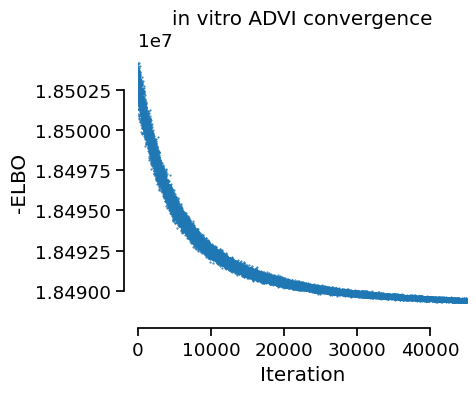

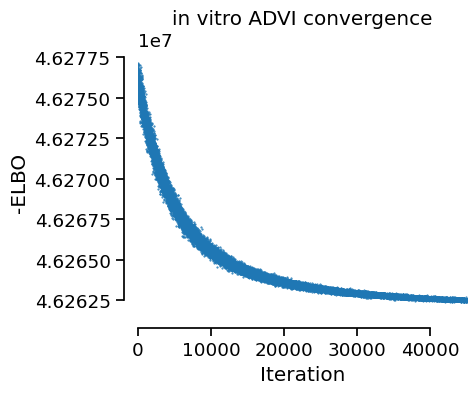

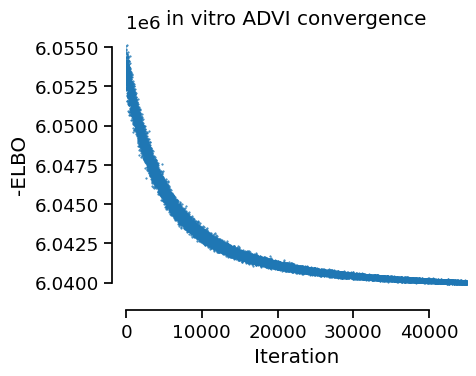

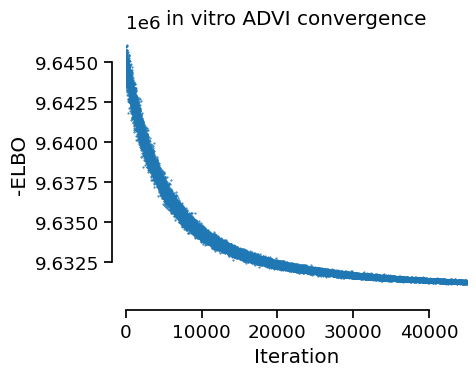

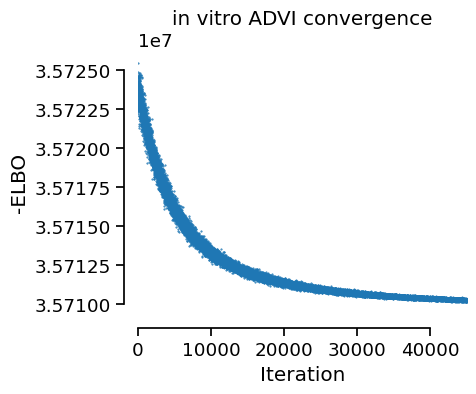

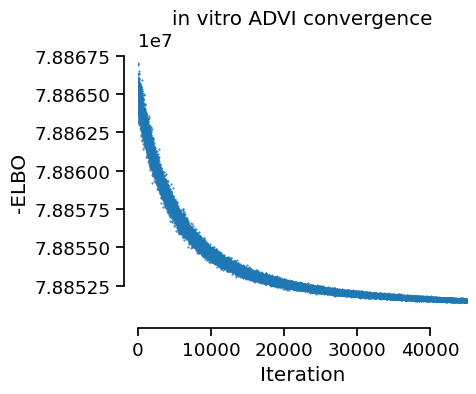

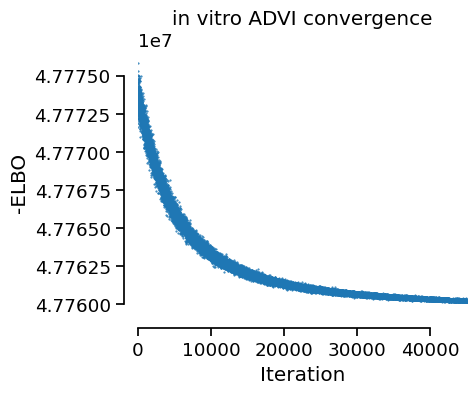

In [10]:
trace_0 = run_BayesInf(BIOMD64_0)
trace_0 = run_BayesInf(BIOMD64_0)
trace_1 = run_BayesInf(BIOMD64_1)
trace_2 = run_BayesInf(BIOMD64_2)
trace_3 = run_BayesInf(BIOMD64_3)
trace_4 = run_BayesInf(BIOMD64_4)
trace_5 = run_BayesInf(BIOMD64_5)


In [11]:
all_traces = [trace_0, trace_1, trace_2, trace_3, trace_4, trace_5]

### Plotting ADVI results

In [13]:
Ex_0 = (trace_0['posterior']['Ex']).to_numpy().squeeze()#.transpose(1, 2, 0)
Ex_1 = (trace_1['posterior']['Ex']).to_numpy().squeeze()#.transpose(1, 2, 0)
Ex_2 = (trace_2['posterior']['Ex']).to_numpy().squeeze()#.transpose(1, 2, 0)
Ex_3 = (trace_3['posterior']['Ex']).to_numpy().squeeze()#.transpose(1, 2, 0)
Ex_4 = (trace_4['posterior']['Ex']).to_numpy().squeeze()#.transpose(1, 2, 0)
Ex_5 = (trace_5['posterior']['Ex']).to_numpy().squeeze()#.transpose(1, 2, 0)
all_Exs = [Ex_0, Ex_1 ,Ex_2, Ex_3, Ex_4, Ex_5]

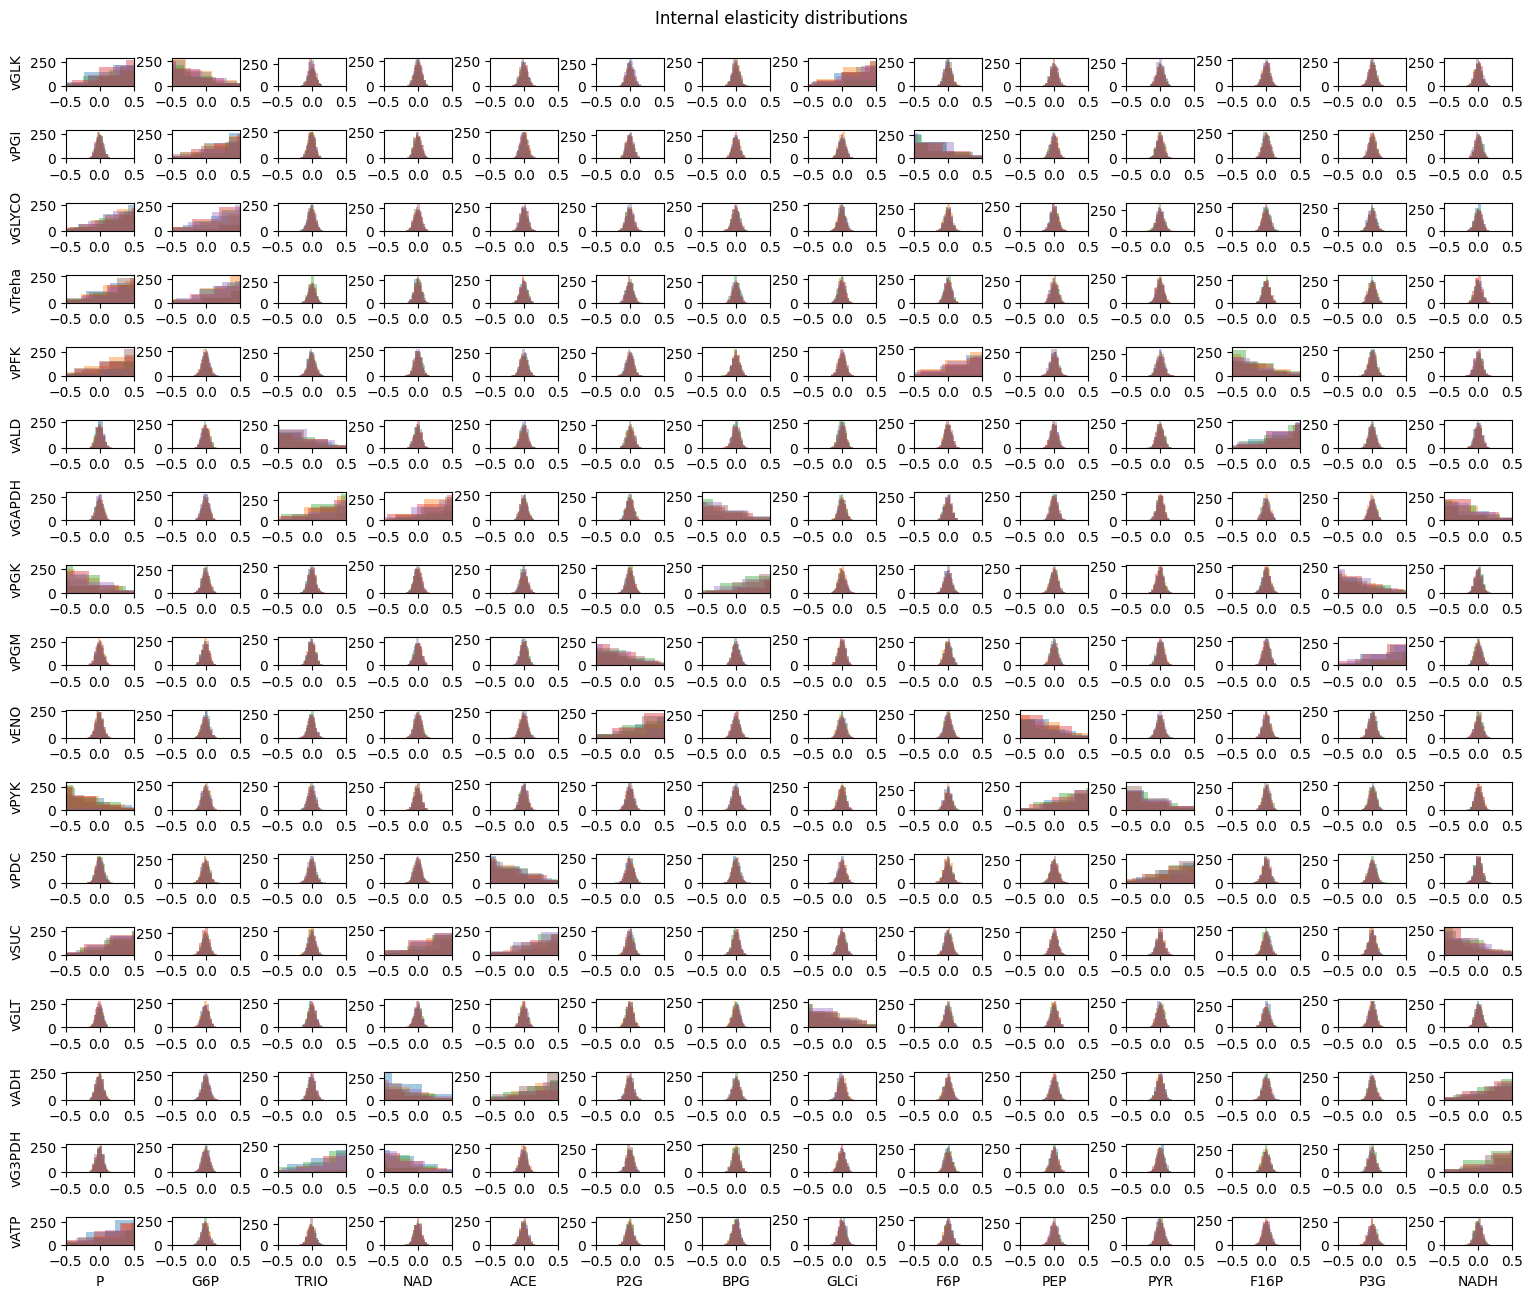

In [14]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for Ex_trace in all_Exs:
  Ex_trace = Ex_trace.transpose(1,2,0)
  for i in range(17):
    for ii in range(14):
      axs[i,ii].hist(Ex_trace[i,ii,:], alpha=0.4)
      axs[i,ii].set_xlim([-0.5,0.5])

      if ii == 0:
        axs[i,ii].set_ylabel(r.getReactionIds()[i])
      if i == 16: 
        axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

## Plotting MCC and FCC comparisons

In [15]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [16]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


In [19]:
for i, bmca in enumerate(all_BIOMD64):
    postCCC, postFCC = estimate_CCs(bmca, all_Exs[i])
    ADH_idx = r.getReactionIds().index('vADH')
    ADH_FCCs = pd.DataFrame(postFCC[:,:, ADH_idx], columns=r.getReactionIds())

    ADH_FCCs.plot(kind='box', colormap='winter')
    plt.title(f'FCCs for vADH, after Bayesian inference-Ex_{i}')

    for i,val in enumerate(gtFCC.loc['vADH']): # .sort_index()
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC['vADH']), # From the left
                xmax = (i+0.8)/len(gtFCC['vADH']), 
                c='red') # To the right
        
    plt.xticks(rotation=-70)
    plt.ylim((-5,5))

ValueError: operands could not be broadcast together with shapes (23,17) (23,11) 